In [1]:
### Wastewater Surveillance for Covid-19 Virus MUN 数据处理

In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, cross_validate

In [3]:
# Load data

df = pd.read_excel('New Microsoft Excel Worksheet.xlsx')
print(df.head())


        Date Sample Location      Time   Sample ID Positive or Negative  \
0 2021-04-16      St. John's       NaN         NaN                  NaN   
1 2021-04-17      St. John's       NaN         NaN                  NaN   
2 2021-04-18      St. John's       NaN         NaN                  NaN   
3 2021-04-19      St. John's       NaN         NaN                  NaN   
4 2021-04-20      St. John's  08:00:00  4400-9-012             Negative   

   N1- Ct  N2- Ct  cp/mL  Flow Normalized (cp/mL per m3/d)  \
0     NaN     NaN    NaN                               NaN   
1     NaN     NaN    NaN                               NaN   
2     NaN     NaN    NaN                               NaN   
3     NaN     NaN    NaN                               NaN   
4     0.0     0.0    0.0                               0.0   

   Population Normalized (cp/mL per person)  ...    pH Sample Temp (oC)  \
0                                       NaN  ...   NaN              NaN   
1                         

In [4]:
#  Drop blank rows

df = df.dropna(subset=["cp/mL"])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 4 to 1513
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      501 non-null    datetime64[ns]
 1   Sample Location                           501 non-null    object        
 2   Time                                      501 non-null    object        
 3   Sample ID                                 501 non-null    object        
 4   Positive or Negative                      381 non-null    object        
 5   N1- Ct                                    101 non-null    float64       
 6   N2- Ct                                    501 non-null    float64       
 7   cp/mL                                     501 non-null    float64       
 8   Flow Normalized (cp/mL per m3/d)          501 non-null    float64       
 9   Population Normalized (cp/mL per per

---

In [5]:
# 1. Separate water samples vs. filter paper samples
#    A sample ID ending with "-1" is considered filter paper; otherwise water.
#    新增SampleType列区分二者

df["SampleType"] = df["Sample ID"].apply(
    lambda x: "Filter" if str(x).endswith("-1") else "Water"
)

print(df['SampleType'].value_counts())

SampleType
Water     377
Filter    124
Name: count, dtype: int64


In [6]:
# 2. 回归 基础 Sample ID to match water vs. filter pairs
#    If a Sample ID ends with “-1”, we remove the suffix so we can match it back to water sample ID.
def remove_filter_suffix(sample_id):
    sample_id_str = str(sample_id)
    if sample_id_str.endswith("-1"):
        return sample_id_str[:-2]  # remove the trailing '-1' 返回从字符串开始到倒数第二个字符之前的所有字符
    return sample_id_str

df["BaseSampleID"] = df["Sample ID"].apply(remove_filter_suffix)

#print(df['BaseSampleID'].unique())

In [7]:
# 3. Create separate dataframes for water and filter samples
df_water = df[df["SampleType"] == "Water"].copy()
df_filter = df[df["SampleType"] == "Filter"].copy()

print("Water samples shape:", df_water.shape)
print("Filter samples shape:", df_filter.shape)

Water samples shape: (377, 29)
Filter samples shape: (124, 29)


In [8]:
# 3. 合并 water & filter data 共有的几个列 
#    相同的列只保留一个 match by Date, Sample Location, and the new BaseSampleID
#    Using “outer” join to preserve unmatched water samples and unmatched filter samples

merged = pd.merge(
    df_water,
    df_filter,
    on=["Date", "Sample Location", "BaseSampleID"],
    suffixes=("_water", "_filter"),
    how="outer"
)

In [9]:
print(merged.columns)


Index(['Date', 'Sample Location', 'Time_water', 'Sample ID_water',
       'Positive or Negative_water', 'N1- Ct_water', 'N2- Ct_water',
       'cp/mL_water', 'Flow Normalized (cp/mL per m3/d)_water',
       'Population Normalized (cp/mL per person)_water', 'Sample Type_water',
       'Composite Type_water', 'Composite Duration (h)_water',
       'Wastewater Flow (m3/d)_water', 'Wastewater Flow (L/s)_water',
       'Air Temp (oC)_water', 'Precip as rain in Last 24 hrs (mm)_water',
       'pH_water', 'Sample Temp (oC)_water', 'Population Serviced_water',
       'Sample Temp at Lab (oC)_water', 'Notes_water', 'S_Sdel_percent_water',
       'S_SN501Y_percent_water', 'S_D377Y_percent_water',
       'S_Sdel_VO_percent_water', 'S_SN501Y_VO_percent_water',
       'SampleType_water', 'BaseSampleID', 'Time_filter', 'Sample ID_filter',
       'Positive or Negative_filter', 'N1- Ct_filter', 'N2- Ct_filter',
       'cp/mL_filter', 'Flow Normalized (cp/mL per m3/d)_filter',
       'Population Normal

---

In [82]:
## 1. match data

matched_data = merged.dropna(subset=["cp/mL_water", "cp/mL_filter"]) # 二次确认
X = matched_data[["cp/mL_water"]].values
y = matched_data["cp/mL_filter"].values


### 0. 散点图

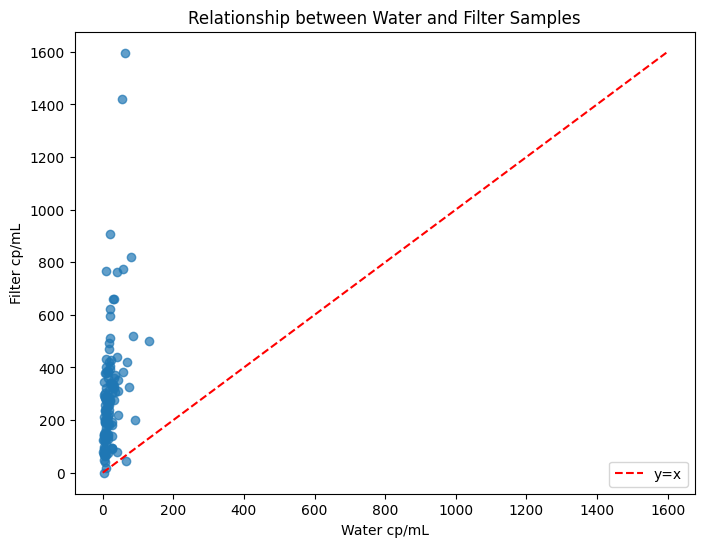

In [12]:
import matplotlib.pyplot as plt

#  'cp/mL_water' 和 'cp/mL_filter'
plt.figure(figsize=(8, 6))
plt.scatter(matched_data['cp/mL_water'], matched_data['cp/mL_filter'], alpha=0.7)
plt.xlabel("Water cp/mL")
plt.ylabel("Filter cp/mL")
plt.title("Relationship between Water and Filter Samples")

# 绘制参考线 y = x（理想情况下两者相等）
min_val = min(matched_data['cp/mL_water'].min(), matched_data['cp/mL_filter'].min())
max_val = max(matched_data['cp/mL_water'].max(), matched_data['cp/mL_filter'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y=x")

plt.legend()
plt.show()


Fitted line: Log(Filter cp/mL) = 0.500 * Log(Water cp/mL) + 4.046
R^2: 0.224


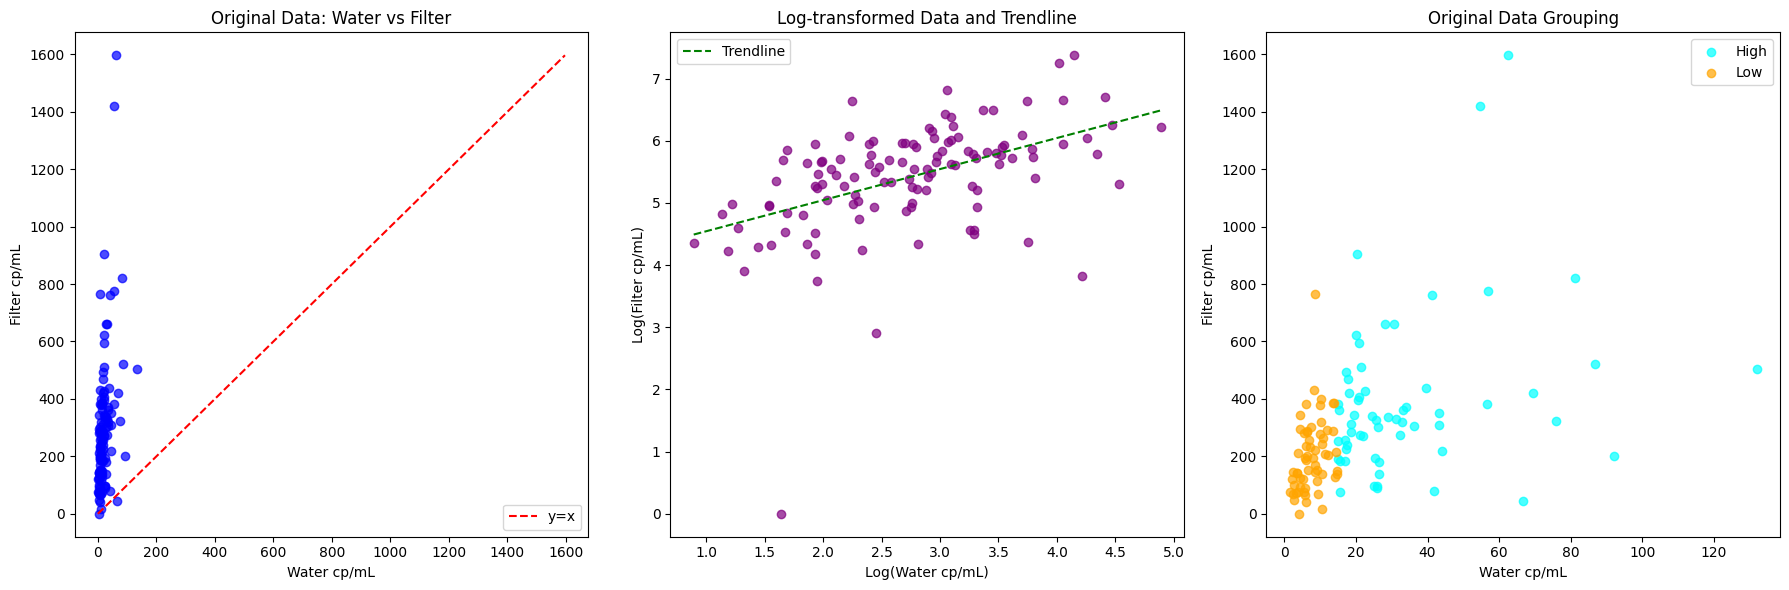

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a new DataFrame for scatter plot processing so that matched_data remains unchanged
scatter_data = matched_data.copy()

# ============================
# 1. Data Transformation: Apply log1p transform on cp/mL data
# ============================
scatter_data.loc[:, 'log_cp/mL_water'] = np.log1p(scatter_data['cp/mL_water'])
scatter_data.loc[:, 'log_cp/mL_filter'] = np.log1p(scatter_data['cp/mL_filter'])

# ============================
# 2. Trendline Fitting: Fit a linear model on the log-transformed data
# ============================
X = scatter_data['log_cp/mL_water'].values.reshape(-1, 1)
y = scatter_data['log_cp/mL_filter'].values
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Print the fitted linear equation and R^2 value
slope = lin_reg.coef_[0]
intercept = lin_reg.intercept_
r2 = lin_reg.score(X, y)
print("Fitted line: Log(Filter cp/mL) = {:.3f} * Log(Water cp/mL) + {:.3f}".format(slope, intercept))
print("R^2: {:.3f}".format(r2))

# Construct the fitted trendline
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = lin_reg.predict(x_line)

# ============================
# 3. Grouping: Divide the data into Low and High groups based on the median of 'cp/mL_water'
# ============================
median_water = scatter_data['cp/mL_water'].median()
scatter_data.loc[:, 'group'] = scatter_data['cp/mL_water'].apply(lambda x: 'Low' if x <= median_water else 'High')

# ============================
# 4. Plotting
# - Subplot 1: Original scatter plot with the reference line y=x
# - Subplot 2: Log-transformed scatter plot with fitted trendline
# - Subplot 3: Grouped original data scatter plot
# ============================
plt.figure(figsize=(18, 6))

# Subplot 1: Original Data Scatter Plot with y=x reference line
plt.subplot(1, 3, 1)
plt.scatter(scatter_data['cp/mL_water'], scatter_data['cp/mL_filter'], alpha=0.7, color='blue')
plt.xlabel("Water cp/mL")
plt.ylabel("Filter cp/mL")
plt.title("Original Data: Water vs Filter")
min_val = min(scatter_data['cp/mL_water'].min(), scatter_data['cp/mL_filter'].min())
max_val = max(scatter_data['cp/mL_water'].max(), scatter_data['cp/mL_filter'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y=x")
plt.legend()

# Subplot 2: Log-transformed Data Scatter Plot with Fitted Trendline
plt.subplot(1, 3, 2)
plt.scatter(scatter_data['log_cp/mL_water'], scatter_data['log_cp/mL_filter'], alpha=0.7, color='purple')
plt.plot(x_line, y_line, color='green', linestyle='--', label='Trendline')
plt.xlabel("Log(Water cp/mL)")
plt.ylabel("Log(Filter cp/mL)")
plt.title("Log-transformed Data and Trendline")
plt.legend()

# Subplot 3: Grouped Original Data Scatter Plot
plt.subplot(1, 3, 3)
colors = {'Low': 'orange', 'High': 'cyan'}
for group_name, group_data in scatter_data.groupby('group'):
    plt.scatter(group_data['cp/mL_water'], group_data['cp/mL_filter'],
                alpha=0.7, label=group_name, color=colors[group_name])
plt.xlabel("Water cp/mL")
plt.ylabel("Filter cp/mL")
plt.title("Original Data Grouping")
plt.legend()

plt.tight_layout()
plt.show()


---

### 1. ANN model

In [14]:
print("X (Water cp/mL):")
print(X[:5])
print("y (Filter cp/mL):")
print(y[:5])

print("X shape:", X.shape)
print("y shape:", y.shape)


X (Water cp/mL):
[[62.38183243]
 [54.80015743]
 [20.04339171]
 [44.14866179]
 [15.03234491]]
y (Filter cp/mL):
[1596.47837373 1419.78366532  622.76137492  219.08967461  254.28303028]
X shape: (120, 1)
y shape: (120,)


In [15]:
## 2. Split into train/test sets 8/2
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [74]:
## 3. Define a simple ANN model (using scikit-learn MLPRegressor)
mlp = MLPRegressor(hidden_layer_sizes=(10, 10),  # 有两层隐藏层，每层各 5 个神经元
                   activation='relu',
                   solver='lbfgs',             # 小数据集下效果可能更好
                   alpha=0.0003,                # 正则化参数，防止过拟合
                   max_iter=500,
                   random_state=42)

In [75]:
### 3.1 交叉验证
###     设置K折交叉验证

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [76]:
### 3.2 使用 cross_val_score 进行交叉验证，度量指标为负均方误差

scoring = {
    'mse': 'neg_mean_squared_error',   # 均方误差(负)
    'mae': 'neg_mean_absolute_error',  # 平均绝对误差(负)
    'r2': 'r2'                         # 决定系数
}

cv_results = cross_validate(
    estimator=mlp,
    X=X,
    y=y,
    scoring=scoring,
    cv=kf,
    return_train_score=False  # 只关心测试集分数
)



In [77]:
### 3.3 提取并还原 MSE、MAE（由于 cross_validate 返回的是负值，需要取反）
mse_scores = -cv_results['test_mse']
mae_scores = -cv_results['test_mae']
r2_scores = cv_results['test_r2']

print("MSE for each fold:", mse_scores)
print("Average MSE across all folds:", mse_scores.mean())
print("Std of MSE:", mse_scores.std(), "\n")

print("MAE for each fold:", mae_scores)
print("Average MAE across all folds:", mae_scores.mean())
print("Std of MAE:", mae_scores.std(), "\n")

print("R2 for each fold:", r2_scores)
print("Average R2 across all folds:", r2_scores.mean())
print("Std of R2:", r2_scores.std())

MSE for each fold: [68280.62817118 28362.74503205 39190.39201964 16521.11804596
 82523.96077261]
Average MSE across all folds: 46975.76880828729
Std of MSE: 24706.733832283826 

MAE for each fold: [126.21244204 128.57787328 144.25555177 105.22715087 202.83671199]
Average MAE across all folds: 141.4219459887449
Std of MAE: 33.12450818339444 

R2 for each fold: [ 0.24150109  0.14744821  0.24006364 -0.63416507 -0.01247837]
Average R2 across all folds: -0.003526099926715731
Std of R2: 0.3286192863199408


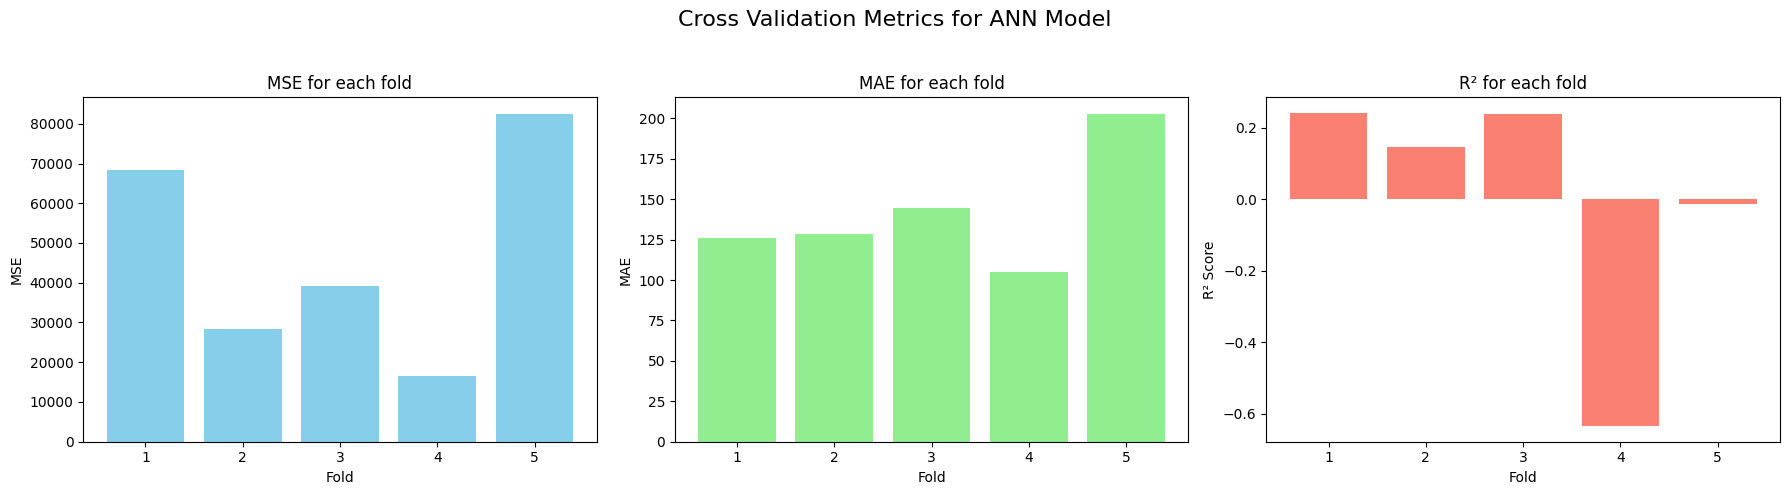

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 mse_scores, mae_scores, r2_scores 已经计算得到
# 创建折数索引，这里有5折
folds = np.arange(1, len(mse_scores) + 1)

plt.figure(figsize=(18, 5))

# 绘制 MSE 柱状图
plt.subplot(1, 3, 1)
plt.bar(folds, mse_scores, color='skyblue')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE for each fold')

# 绘制 MAE 柱状图
plt.subplot(1, 3, 2)
plt.bar(folds, mae_scores, color='lightgreen')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('MAE for each fold')

# 绘制 R² 柱状图
plt.subplot(1, 3, 3)
plt.bar(folds, r2_scores, color='salmon')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('R² for each fold')

plt.suptitle('Cross Validation Metrics for ANN Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


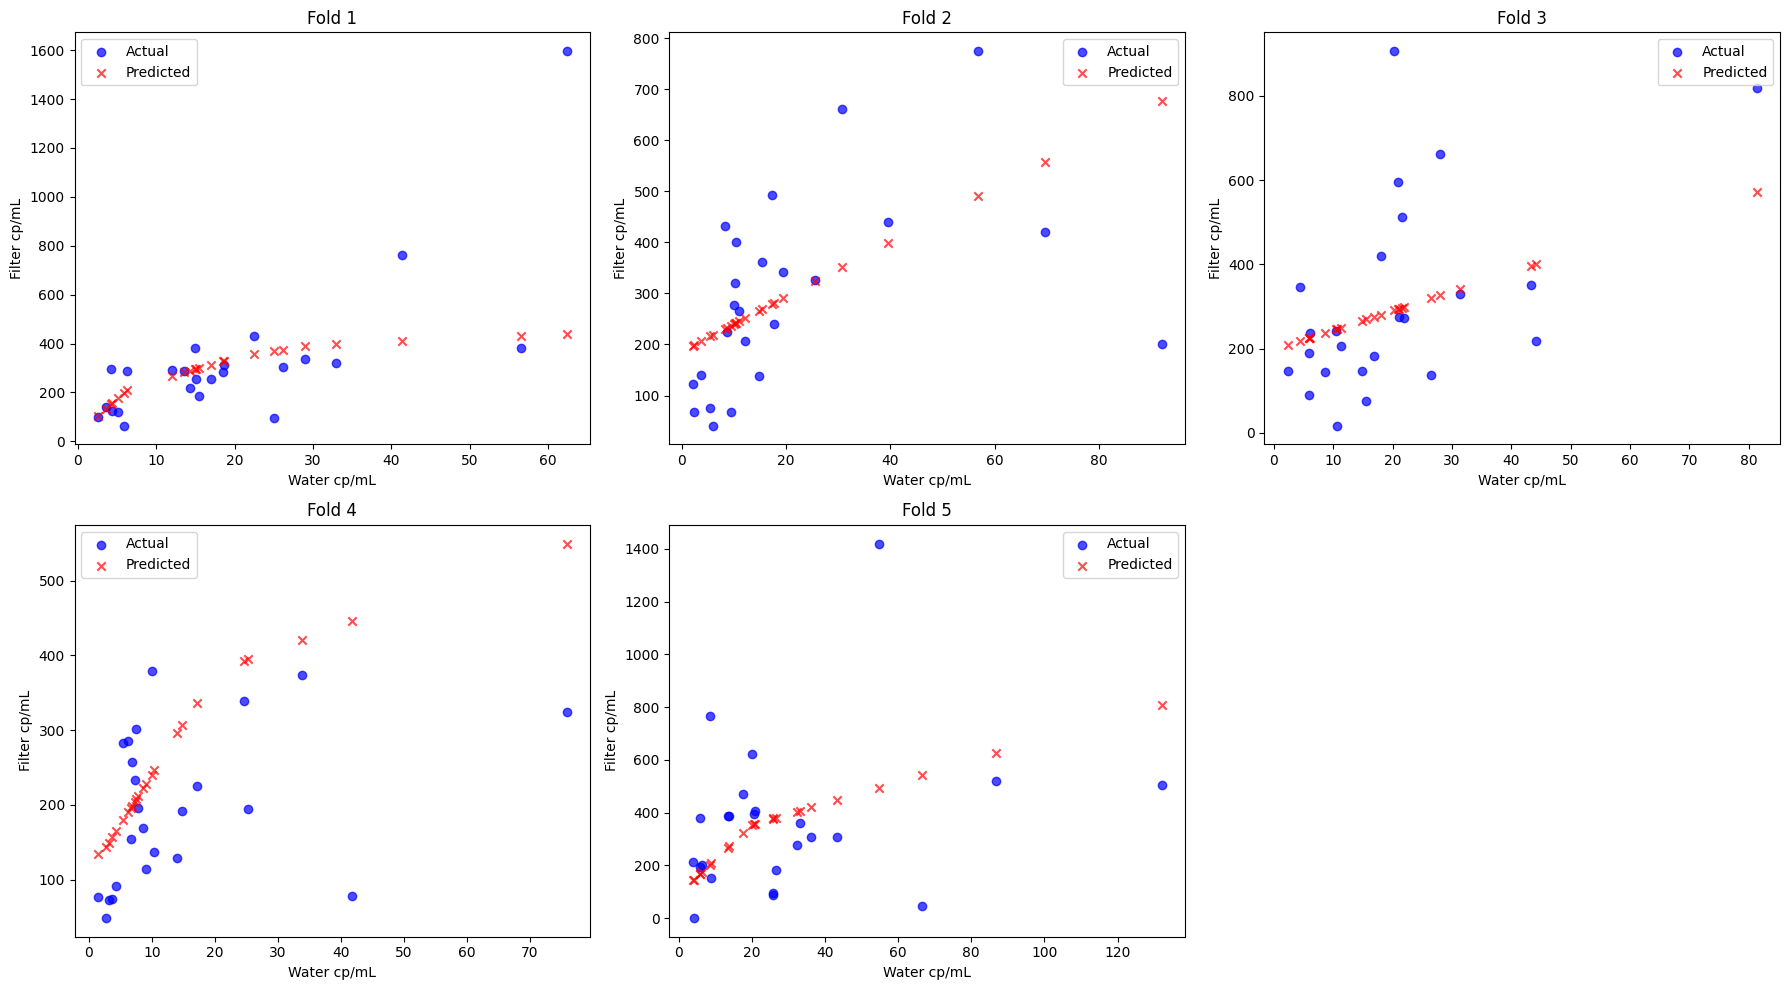

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone

folds = list(kf.split(X, y))
n_folds = len(folds)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 2行×3列
axes = axes.flatten()  # 将二维的axes数组展开，方便按索引访问

for i, (train_idx, test_idx) in enumerate(folds, start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 克隆模型，确保每一折独立训练
    mlp_fold = clone(mlp)
    mlp_fold.fit(X_train, y_train)
    y_pred = mlp_fold.predict(X_test)

    ax = axes[i - 1]  # 获取对应子图
    ax.scatter(X_test, y_test, color='blue', alpha=0.7, label='Actual')
    ax.scatter(X_test, y_pred, color='red', marker='x', alpha=0.7, label='Predicted')
    ax.set_xlabel("Water cp/mL")
    ax.set_ylabel("Filter cp/mL")
    ax.set_title(f"Fold {i}")
    ax.legend()

# 如果折数少于子图数量，隐藏剩余的空子图
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


---
---

In [69]:
## 3. Define a simple ANN model (using scikit-learn MLPRegressor)
mlp = MLPRegressor(hidden_layer_sizes=(10, 10),  # 有两层隐藏层，每层各 5 个神经元
                   activation='relu',
                   solver='lbfgs',             # 小数据集下效果可能更好
                   alpha=0.0003,                # 正则化参数，防止过拟合
                   max_iter=500,
                   random_state=42)

In [70]:
## 4. Train the model
mlp.fit(X_train, y_train)

MLPRegressor(alpha=0.0003, hidden_layer_sizes=(10, 10), max_iter=500,
             random_state=42, solver='lbfgs')

In [ ]:

# 5. Evaluate performance on test data
y_pred = mlp.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R2 Score:", r2)


Test MSE: 82523.96077261317
Test MAE: 202.83671198747493
Test R2 Score: -0.012478370345568868


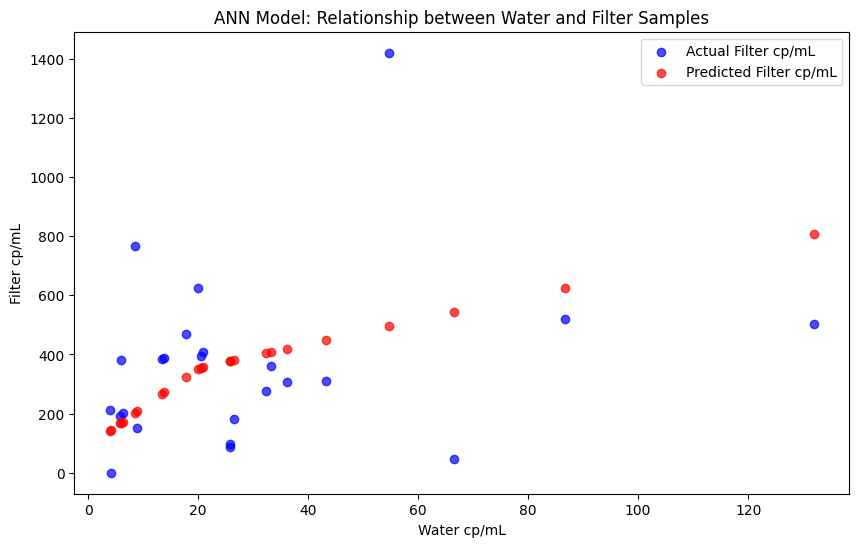

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# 绘制实际的过滤纸 cp/mL 数据（y_test）和对应的水样 cp/mL（X_test）
plt.scatter(X_test, y_test, color='blue', alpha=0.7, label='Actual Filter cp/mL')

# 绘制通过 ANN 模型预测的过滤纸 cp/mL 数据（y_pred）
plt.scatter(X_test, y_pred, color='red', alpha=0.7, label='Predicted Filter cp/mL')

plt.xlabel("Water cp/mL")
plt.ylabel("Filter cp/mL")
plt.title("ANN Model: Relationship between Water and Filter Samples")
plt.legend()
plt.show()
